In [1]:
from ticl.prediction.tabpfn import TabPFNClassifier
from ticl.dataloader import get_dataloader
from ticl.model_builder import get_model, get_y_encoder, get_criterion
from ticl.train import eval_criterion
import torch
import numpy as np
import os 
import pandas as pd
from tqdm import tqdm
import lightning as L
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

root_dir = os.path.dirname(os.getcwd())

/datadrive/anaconda3/envs/torch23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [2]:
n_test_samples = 1000
n_rep = 20
num_features = 100

prior_default_config = {
    'num_features': num_features, 
    'n_samples': 1152, 
    'eval_positions': [1094.3999999999999], 
    'heterogeneous_batches': False, 
    'multiclass_loss_type': 'nono', 
    'prior_type': 'prior_bag', 
    'prior_bag': {
        'prior_bag_exp_weights_1': {
            'distribution': 'uniform', 
            'min': 2.0, 
            'max': 10.0
        }
    }, 
    'mlp': {
        'pre_sample_causes': True, 
        'sampling': 'normal', 
        'prior_mlp_scale_weights_sqrt': True, 
        'random_feature_rotation': True, 
        'num_layers': {
            'distribution': 'meta_gamma', 
            'max_alpha': 2, 
            'max_scale': 3, 
            'round': True, 
            'lower_bound': 2
        }, 
        'prior_mlp_hidden_dim': {
            'distribution': 'meta_gamma', 
            'max_alpha': 3,
            'max_scale': 100, 
            'round': True, 
            'lower_bound': 4
        }, 
        'prior_mlp_dropout_prob': {
            'distribution': 'meta_beta', 
            'scale': 0.6, 
            'min': 0.1, 
            'max': 5.0
        }, 
        'init_std': {
            'distribution': 'log_uniform', 
            'min': 0.01, 
            'max': 12
        }, 
        'noise_std': {
            'distribution': 'log_uniform', 
            'min': 0.0001, 
            'max': 0.5
        }, 
        'num_causes': {
            'distribution': 'meta_gamma', 
            'max_alpha': 3, 
            'max_scale': 7, 
            'round': True, 
            'lower_bound': 2
        }, 
        'is_causal': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
        }, 
        'pre_sample_weights': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
            }, 
        'y_is_effect': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
        }, 
        'prior_mlp_activations': {
            'distribution': 'meta_choice', 
            'choice_values': [torch.nn.Tanh, torch.nn.Identity, torch.nn.ReLU]
        }, 
        'block_wise_dropout': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
        }, 
        'sort_features': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
        }, 
        'in_clique': {
            'distribution': 'meta_choice', 
            'choice_values': [True, False]
        }, 
        'add_uninformative_features': False
    }, 
    'gp': {
        'outputscale': {
            'distribution': 'log_uniform', 
            'min': 1e-05, 
            'max': 8
        }, 
        'lengthscale': {
            'distribution': 'log_uniform', 
            'min': 1e-05, 
            'max': 8
        }, 
        'noise': {
            'distribution': 'meta_choice', 
            'choice_values': [1e-05, 0.0001, 0.01]
        }, 
        'sampling': 'normal'
    }, 
    'step_function': {
        'max_steps': 1, 
        'sampling': 'uniform'
    }, 
    'classification': {
        'max_num_classes': 10, 
        'num_classes': {
            'distribution': 'uniform_int', 
            'min': 2, 
            'max': 10
        }, 
        'balanced': False, 
        'output_multiclass_ordered_p': 0.0, 
        'multiclass_max_steps': 10, 
        'multiclass_type': 'rank', 
        'categorical_feature_p': 0.2, 
        'nan_prob_no_reason': 0.0, 
        'nan_prob_a_reason': 0.0, 
        'set_value_to_nan': 0.9, 
        'num_features_sampler': 'uniform', 
        'pad_zeros': True, 
        'feature_curriculum': False
    }, 
    'boolean': {
        'max_fraction_uninformative': 0.5, 
        'p_uninformative': 0.5
    }
}

data_default_config = {
    'batch_size': 1, 
    'num_steps': 1, 
    'min_eval_pos': 2, 
    'random_n_samples': 0, 
    'n_test_samples': 0
}

device = 'cuda'

# Models

In [3]:
ssm_default_config = {
    'emsize': 512, 
    'nlayers': 1, 
    'dropout': 0.0, 
    'nhid_factor': 2, 
    'nhead': 4, 
    'ssm_cfg': {
        'd_state': 16, 
        'expand': 1
    }, 
    'local_nhead': 4, 
    'init_method': None, 
    'recompute_attn': True, 
    'pre_norm': False, 
    'y_encoder': 'one_hot', 
    'classification_task': True, 
    'efficient_eval_masking': True, 
    'input_normalization': False, 
    'tabpfn_zero_weights': True, 
    'all_layers_same_init': True, 
    'model': 'linear_attention', 
    'causal_mask': False, 
    'feature_map': 'identity', 
    'norm_output': False
}

transformer_default_config = {
    'emsize': 512, 
    'nlayers': 1, 
    'dropout': 0.0, 
    'nhid_factor': 2, 
    'nhead': 4, 
    'init_method': None, 
    'recompute_attn': True, 
    'pre_norm': False, 
    'y_encoder': 'one_hot', 
    'classification_task': True, 
    'efficient_eval_masking': True, 
    'input_normalization': False, 
    'tabpfn_zero_weights': True, 
    'model': 'standard_attention', 
    'causal_mask': False
}

# Run Experiments

In [4]:
# seqlen_list = [100, 500, 1000, 1500, 2000, 4000, 8000, 16000, 32000, 50000]
seqlen_list = [100, 200, 400, 800, 900, 1000, 1300, 1600, 2000, 2500, 3000]

In [5]:
tabpfn_models = {
    # 'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples10000_08_01_2024_20_58_55': ('SSMTabPFN+10000', 'on_exit'),
    'tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10': ('Non-causal Masked', 1000, 12, 100),
    # 'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50': ('SSMTabPFN+50000', 110, 12),
    # 'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples1000_08_02_2024_17_14_16': ('SSMTabPFN+1000', 'on_exit'),
    # 'ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_08_16_2024_18_14_40': ('TabFlex+50000', 340, 12, 1000),
    'tabpfn_causalmaskTrue_08_28_2024_18_57_29': ('Causal Masked', 120, 12, 100),
    # 'prior_diff_real_checkpoint_n_0': ('TabPFN', 100, 12, 100),
}

L.seed_everything(123)

loss_results = {}
for i in range(n_rep):
    loss_results[i] = {}
    dl = get_dataloader(
        prior_config={**prior_default_config, 'n_samples': max(seqlen_list) + n_test_samples},
        dataloader_config = {**data_default_config},
        device = device,
        model = None,
    )
    (info, x, y), target_y_default, _ = dl.gbm()
    data_default = (info, x, y)

    for model_string in tabpfn_models:
        model_name, epoch, nlayers, max_features = tabpfn_models[model_string]
        loss_results[i][model_name] = {'acc': {}, 'loss': {}}
        
        acc_csv = f'{root_dir}/results/{model_string}_{epoch}_{n_rep}_{n_test_samples}_acc.csv'
        loss_csv = f'{root_dir}/results/{model_string}_{epoch}_{n_rep}_{n_test_samples}_loss.csv'
        
        # if os.path.exists(acc_csv) and os.path.exists(loss_csv): 
        #     loss_results[model_name]['acc'] = pd.read_csv(acc_csv, index_col=0).to_dict()
        #     loss_results[model_name]['loss'] = pd.read_csv(loss_csv, index_col=0).to_dict()
        #     continue
        
        if 'ssm_tabpfn' in model_string:
            from ticl.models.ssm_tabpfn import SSMTabPFN
            ssm_config = {**ssm_default_config, 'nlayers': nlayers}
            model = SSMTabPFN(
                n_out=prior_default_config['classification']['max_num_classes'], 
                n_features=max_features, 
                y_encoder_layer=get_y_encoder({'ssm': ssm_config, 'prior': prior_default_config}, 'ssm'), 
                **ssm_config
            )
        else:
            from ticl.models.tabpfn import TabPFN
            transformer_config = {**transformer_default_config, 'nlayers': nlayers}
            model = TabPFN(
                n_out=prior_default_config['classification']['max_num_classes'], 
                n_features=max_features, 
                y_encoder_layer=get_y_encoder({'transformer': transformer_config, 'prior': prior_default_config}, 'transformer'), 
                **transformer_config
            )
            
        model_state = torch.load(f'{root_dir}/models_diff/{model_string}_epoch_{epoch}.cpkt', map_location='cpu')[0]

        for k, v in model.state_dict().items():
            if k in model_state and model_state[k].shape != v.shape:
                model_state.pop(k)
        model.load_state_dict(model_state, strict = False)
        model.to(device)
        model.eval()
        
        for seqlen in tqdm(seqlen_list):
            single_eval_pos = seqlen

            
            data = (info, x[:(seqlen+n_test_samples),:,:max_features], y[:(seqlen+n_test_samples),:])
            target_y = target_y_default[:(seqlen+n_test_samples),:]
            
            output = model(
                tuple(e.to(device) if torch.is_tensor(e) else e for e in data) 
                if isinstance(data, tuple) else data.to(device), 
                single_eval_pos=single_eval_pos,
            )
            
            pred_y = output.argmax(dim=2)
            acc = (pred_y == target_y[single_eval_pos:]).reshape(-1).float().mean().item()
            
            criterion = get_criterion(prior_default_config['classification']['max_num_classes'])
            loss, nan_share = eval_criterion(
                criterion,
                target_y[single_eval_pos:].to(device),
                output,
                device = device,
                n_out = model.n_out
            )
            
            loss = loss.item()
        
        
            loss_results[i][model_name]['acc'][seqlen] = acc
            loss_results[i][model_name]['loss'][seqlen] = loss
    
metric_table = {}
for model_string in tabpfn_models:
    model_name, epoch, nlayers, max_features = tabpfn_models[model_string]
    metric_table[model_name] = {}
    for metric in ['acc', 'loss']:
        metric_table[model_name][metric] = {}
        for seqlen in seqlen_list:
            metric_table[model_name][metric][seqlen] = []
            for i in range(n_rep):
                metric_table[model_name][metric][seqlen].append(loss_results[i][model_name][metric][seqlen])

for model_string in tabpfn_models:
    model_name, epoch, nlayers, max_features = tabpfn_models[model_string]
    # save loss results to csv
    df = pd.DataFrame(metric_table[model_name]['acc'])
    df.to_csv(f'{root_dir}/results/{model_string}_{epoch}_{n_rep}_{n_test_samples}_acc.csv')

    df = pd.DataFrame(metric_table[model_name]['loss'])
    df.to_csv(f'{root_dir}/results/{model_string}_{epoch}_{n_rep}_{n_test_samples}_loss.csv')

    
    
    

Seed set to 123


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 43.18it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.74it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.78it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.99it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.56it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.82it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.18it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.50it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.60it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.75it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.29it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.60it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.49it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 53.77it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 41.63it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.04it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.95it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.92it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.73it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.79it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.92it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.87it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.57it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.99it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.83it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.99it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.85it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 54.58it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.80it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 41.15it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.97it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.00it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.97it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.07it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.09it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 55.99it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.09it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.12it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.00it/s]


Number of parameters in backbone:  25233408


100%|██████████| 11/11 [00:00<00:00, 56.05it/s]


In [19]:
legend_converter = {
    'Non-causal Masked': ('>', '-', '#073B4C'),
    'Causal Masked': ('s', '--', '#DD3497'),
}

# legend_converter = {
#     'Non-causal Masked': ('>', '-', "#82CA9D"),
#     'Causal Masked': ('o', '--', "#8884D8"),
# }

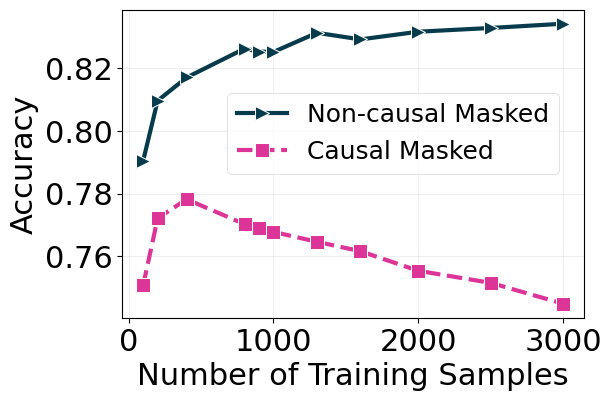

In [20]:
metric = 'acc'

plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 3
markersize = 10

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(left=0.2, bottom=.2, right=0.97, top=0.97, wspace=0.15, hspace = 0.3) #margin of the figure
fig.set_size_inches(6, 4) #exact size of the figure
for i, model_name in enumerate(metric_table):

    df = pd.DataFrame(metric_table[model_name][metric])
    # Assuming your data is in a DataFrame called 'df'
    # If it's not, you'll need to load it first

    # Transpose the DataFrame so each column becomes a data point
    df_transposed = df.transpose()

    # Calculate mean and standard deviation
    mean = df_transposed.mean(axis=1)
    std = df_transposed.std(axis=1)

    # Create x-values (assuming column names are the x-values)
    x = df.columns.astype(int)

    sns.lineplot(
        x=x, y=mean, ax = ax, label = model_name, 
        linestyle = legend_converter[model_name][1], 
        color = legend_converter[model_name][2], 
        linewidth = lw,
        marker = legend_converter[model_name][0],
        markersize = markersize,
    )

    # ax.fill_between(x, mean-std, mean+std, alpha=0.3)

    # Customize the plot
    # plt.xscale('log')  # Use log scale for x-axis due to wide range of values
plt.xlabel('Number of Training Samples', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
# plt.title('Mean Value with Confidence Interval')

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
ax.legend(
    fontsize=18, 
    bbox_to_anchor=(.20,0.77), 
    # title = 'S6-Linear', 
)
plt.savefig(f'{root_dir}/figures/causal_non_causal_icl.pdf')